In [1]:
from tqdm import tqdm_notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
##
from google.colab import drive
drive.mount('/gdrive')
import os
os.chdir('/gdrive/My Drive/Colab Notebooks/Uni_MNIST')
from PIL import Image,ImageFont, ImageDraw


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# 1: Visualize the 'puritanical' seed-images

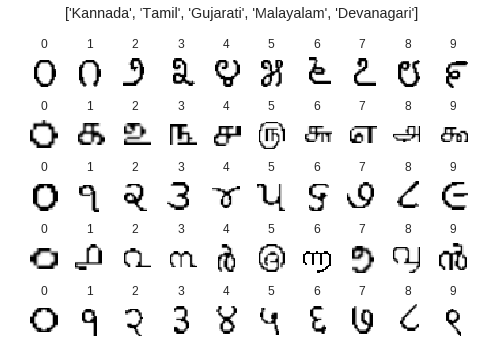

In [2]:
dict_seeds=np.load('dict_seeds.npy')
lang_list=['Kannada', 'Tamil', 'Gujarati', 'Malayalam', 'Devanagari']


plt.figure()
c=1
for lang in lang_list:
  
  for i in range(10):
    plt.subplot(5,10,c)
    c+=1
    plt.imshow(dict_seeds.item().get(lang)[i,:,:])
    plt.title(i)
    plt.axis('off')

  plt.suptitle(lang_list);

# 2: Sanity check for the GAN training dataset images

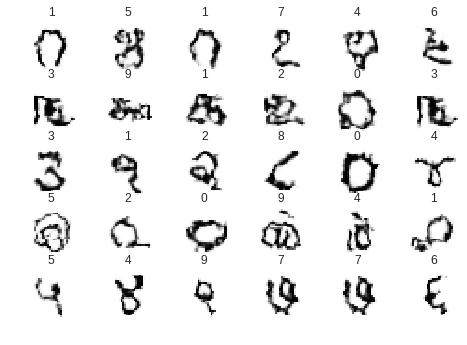

In [3]:
# Sanity check:
n_rows_final=6000
lang_list=['Kannada', 'Tamil', 'Gujarati', 'Malayalam', 'Devanagari']
sampled_labels = np.array([
    [i] * n_rows_final for i in range(10)
]).reshape(-1, 1)
y_train=sampled_labels.flatten()


c=1
for lang in lang_list:
  X=np.load('X_gan_'+lang+'.npy')
  for i in range(6):
    plt.subplot(5,6,c)
    c+=1
    ind=np.random.choice(60000)
    plt.imshow(X[ind,:,:,0])
    plt.title(y_train[ind])
    plt.axis('off')


#Pass the tensors, Train the CNN , store the results:

In [0]:
from __future__ import print_function
import keras
from keras.models import load_model
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.callbacks import ModelCheckpoint,EarlyStopping


def cnn_model():
  # input image dimensions
  img_rows, img_cols = 28, 28
  num_classes=10
  input_shape = (img_rows, img_cols, 1)
  model = Sequential()
  model.add(Conv2D(64, kernel_size=(3, 3),
                   activation='relu',
                   input_shape=input_shape))
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))
  return model

# model_mnist=cnn_model()

def cnn_train(X_train, y_train, X_test, y_test, lang,model_name='None'):
  y_pred_name='y_pred_'+lang+'.npy'
  if(model_name=='None'):
    model_name='model_hybrid_'+lang+'.h5'
  
  score_name='score_hybrid_'+lang+'.npy'

  batch_size = 128
  num_classes = 10
  epochs = 10


  model=cnn_model()
  
  X_train = X_train.astype('float32')
  X_test = X_test.astype('float32')


  X_train /= 255
  X_test /= 255
  print('X_train shape:', X_train.shape)
  print(X_train.shape[0], 'train samples')
  print(X_test.shape[0], 'test samples')
  print(X_train[0].min(),X_train[0].max(),X_test[0].min(),X_test[0].max())

  # convert class vectors to binary class matrices
  Y_train = keras.utils.to_categorical(y_train, num_classes)
  Y_test = keras.utils.to_categorical(y_test, num_classes)



  model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.Adadelta(),
                metrics=['accuracy'])

  # checkpoint
  checkpoint = ModelCheckpoint(model_name, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
  e_s=EarlyStopping(monitor='val_acc',patience=4,  restore_best_weights=True)
  
  callbacks_list = [checkpoint,e_s]


  model.fit(X_train, Y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=0,
            callbacks=callbacks_list,
            validation_data=(X_test, Y_test))
  score = model.evaluate(X_test, Y_test, verbose=0)
  print('Test loss:', score[0])
  print('Test accuracy:', score[1])

  # Saving all the tensors
#   np.save(score_name,score)
#   np.save(y_pred_name,y_pred)
  # model.save(model_name)
  model=load_model(model_name)
  print(X_test.shape)
  y_pred=model.predict_classes(X_test)
  print('Best accuracy:')
  print((y_pred==y_test).sum()/len(y_test))
  return model


In [0]:
lang_list=['Kannada', 'Tamil', 'Gujarati', 'Malayalam', 'Devanagari']
acc_dict_hybrid=dict.fromkeys(lang_list)
acc_dict_hybrid_doped=dict.fromkeys(lang_list)
for l in lang_list:
  acc_dict_hybrid[l]=pd.DataFrame()
  acc_dict_hybrid_doped[l]=pd.DataFrame()

In [6]:
# Genrate the common y_train first!
n_rows_final=6000
sampled_labels = np.array([
    [i] * n_rows_final for i in range(10)
]).reshape(-1, 1)
y_train_gan=sampled_labels.flatten()
# y_train_elastic=np.tile(np.arange(10),6000)
####################################

for lang_iter,lang in enumerate(lang_list):

  print(lang)
  # 1: Load the synthetic tensors for training
  # a: GAN
  X_gan_lang=np.load('X_gan_'+lang+'.npy')
  X_gan_lang=np.round((X_gan_lang.astype(np.float32) * 127.5) + 127.5)
#   # b: Elastic
  X_synth=np.load('X_synth_'+lang+'.npy')
  y_synth=np.load('y_synth_'+lang+'.npy')
#   X_elastic_lang=X_elastic_all[:,10*lang_iter:10*(lang_iter+1),:,:,0]
#   X_elastic_lang=np.expand_dims(X_elastic_lang.reshape(60000, 28, 28),3)
  X_train=np.concatenate([X_gan_lang,X_synth])
  y_train=np.concatenate([y_train_gan,y_synth])
  np.save('X_train_hybrid_'+lang+'.npy',X_train)
  np.save('y_train_hybrid_'+lang+'.npy',y_train)

  # 2: Load the real-world tensors for testing
  X_test=np.load('X_test_'+lang+'.npy')
  y_test=np.load('y_test_'+lang+'.npy')  
  # 3: Train the CNN
  print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
       
  model=cnn_train(X_train, y_train, X_test, y_test, lang)
  X_test=X_test/255
  y_pred=model.predict_classes(X_test)
  # Plot the confusion matrix:
  df_cm=pd.DataFrame(data=np.vstack([y_test,y_pred]).T,columns=['true_vec','pred_vec'])
  c_mat=pd.crosstab(df_cm.true_vec,df_cm.pred_vec)
  #Save the confusion matrix in the accuracy dictionary
  acc_dict_hybrid[lang]=c_mat
np.save('acc_dict_hybrid.npy',acc_dict_hybrid)

Kannada
(140000, 28, 28, 1) (140000,) (1280, 28, 28, 1) (1280,)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
X_train shape: (140000, 28, 28, 1)
140000 train samples
1280 test samples
0.0 0.99607843 0.0 1.0
Instructions for updating:
Use tf.cast instead.
Train on 140000 samples, validate on 1280 samples
Epoch 1/10
140000/140000 [==============================] - 36s 254us/step - loss: 0.1339 - acc: 0.9580 - val_loss: 1.0244 - val_acc: 0.7023

Epoch 00001: val_acc improved from -inf to 0.70234, saving model to model_hybrid_Kannada.h5
Epoch 2/10
140000/140000 [==============================] - 33s 236us/step - loss: 0.0627 - acc: 0.9794 - val_loss: 0.8466 - val_acc: 0.7383

Epoch 00002: val_acc improved from 0.70234 to 0.73828, saving model to model_hybrid_Kannada.h5
Epoch 3/10
140000/140000 [==============================] - 33s 237us/step - loss: 

In [9]:
for lang in lang_list:
  print(lang)
  # 1: Load the synthetic tensors for training
  X_train=np.load('X_train_hybrid_'+lang+'.npy')
  y_train=np.load('y_train_hybrid_'+lang+'.npy')
  X_test=np.load('X_test_'+lang+'.npy')
  y_test=np.load('y_test_'+lang+'.npy')  
  # Make new training sensors combining both the Synthetic tensors and a little of the test tensors
  X_train_new=np.concatenate([X_train,X_test[0:280]])
  y_train_new=np.concatenate([y_train,y_test[0:280]])
  X_test_new=X_test[280:]
  y_test_new=y_test[280:]
  # Train the CNN
  m_name='model_hybrid_doped_'+lang+'.h5'
  model=cnn_train(X_train_new, y_train_new, X_test_new, y_test_new, lang,model_name=m_name)
  y_pred=model.predict_classes(X_test_new/255)
  # Plot the confusion matrix:
  df_cm=pd.DataFrame(data=np.vstack([y_test_new,y_pred]).T,columns=['true_vec','pred_vec'])
  c_mat=pd.crosstab(df_cm.true_vec,df_cm.pred_vec)
#   plt.figure()
#   plt.title(lang)
#   sns.heatmap(c_mat, annot=True, fmt="2d")
  acc_dict_hybrid_doped[lang]=c_mat
np.save('acc_dict_hybrid_doped.npy',acc_dict_hybrid_doped)

Kannada
X_train shape: (140280, 28, 28, 1)
140280 train samples
1000 test samples
0.0 0.99607843 0.0 1.0
Train on 140280 samples, validate on 1000 samples
Epoch 1/10
140280/140280 [==============================] - 35s 248us/step - loss: 0.1392 - acc: 0.9567 - val_loss: 0.5989 - val_acc: 0.8020

Epoch 00001: val_acc improved from -inf to 0.80200, saving model to model_hybrid_doped_Kannada.h5
Epoch 2/10
140280/140280 [==============================] - 33s 238us/step - loss: 0.0666 - acc: 0.9785 - val_loss: 0.4804 - val_acc: 0.8530

Epoch 00002: val_acc improved from 0.80200 to 0.85300, saving model to model_hybrid_doped_Kannada.h5
Epoch 3/10
140280/140280 [==============================] - 33s 238us/step - loss: 0.0508 - acc: 0.9833 - val_loss: 0.3758 - val_acc: 0.8810

Epoch 00003: val_acc improved from 0.85300 to 0.88100, saving model to model_hybrid_doped_Kannada.h5
Epoch 4/10
140280/140280 [==============================] - 34s 239us/step - loss: 0.0434 - acc: 0.9856 - val_loss: 0.3

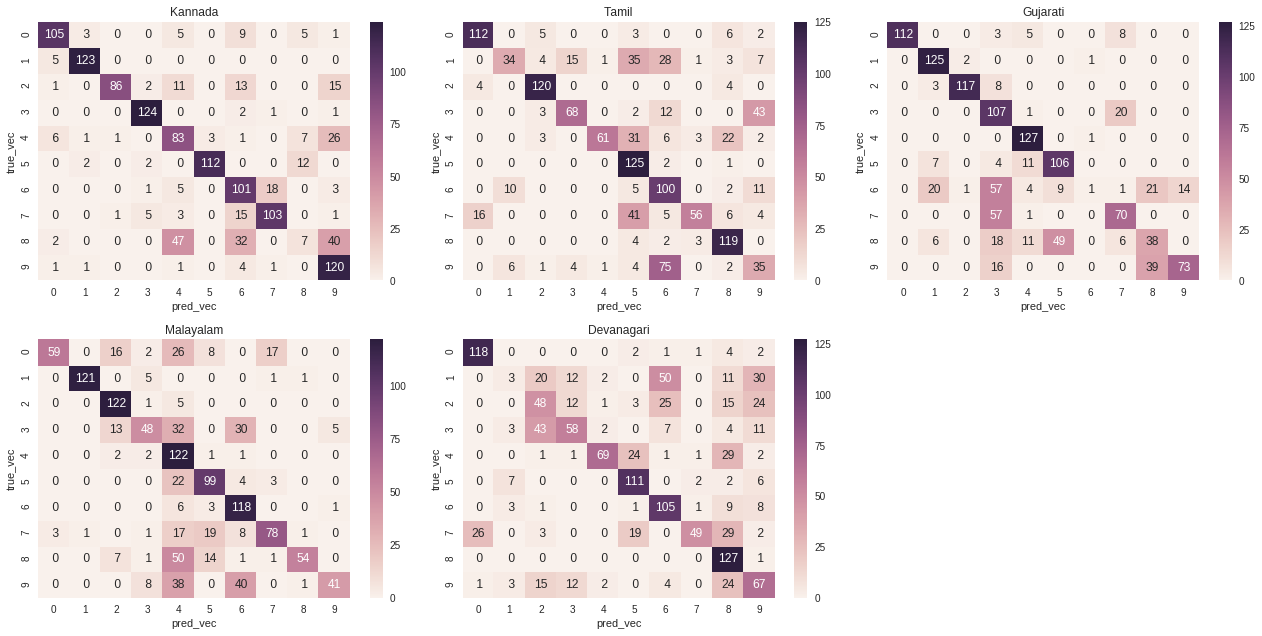

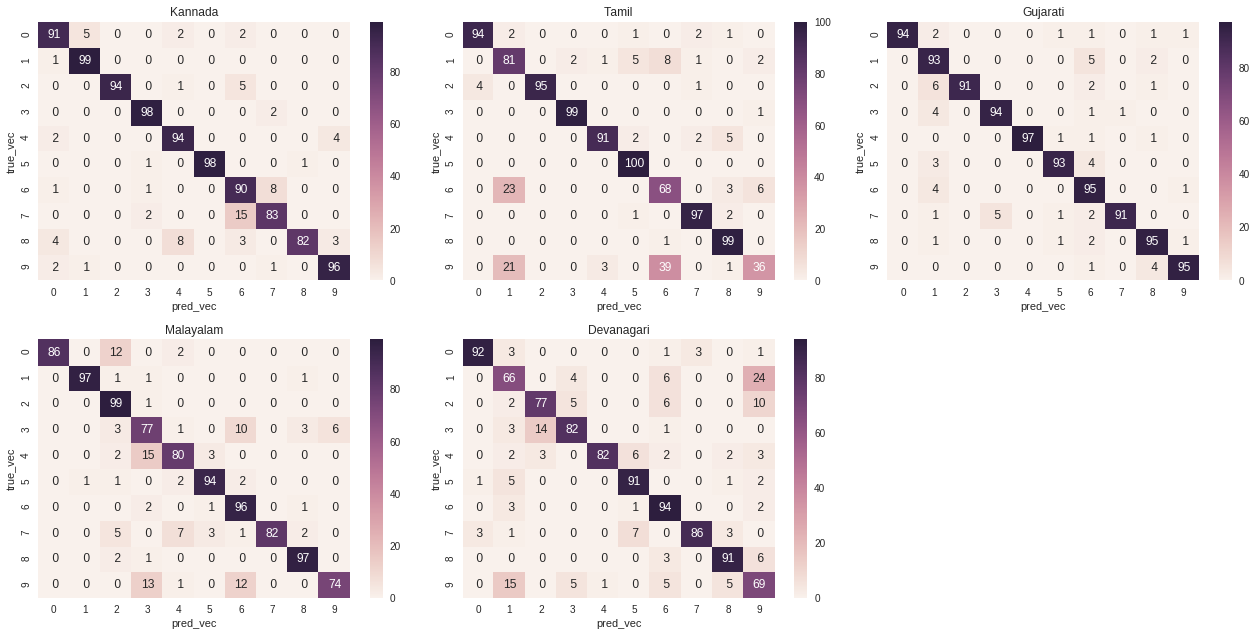

In [10]:
#Visualizing the confusion matrices:
c=1
plt.figure(figsize=(18,9))
for lang in lang_list:
  #Get the confusion matrix in the accuracy dictionary
  c_mat=acc_dict_hybrid[lang] 
  plt.subplot(2,3,c)
  c+=1
  sns.heatmap(c_mat, annot=True, fmt="2d")
  plt.title(lang)
  
  
plt.tight_layout()
plt.savefig('cm_hybrid.png',dpi=100)
###############################################
c=1
plt.figure(figsize=(18,9))
for lang in lang_list:
  #Get the confusion matrix in the accuracy dictionary
  c_mat=acc_dict_hybrid_doped[lang] 
  plt.subplot(2,3,c)
  c+=1
  sns.heatmap(c_mat, annot=True, fmt="2d")
  plt.title(lang)
  
  
plt.tight_layout()
plt.savefig('cm_hybrid_doped.png',dpi=100)